In [6]:
# import stuff
import os
cwd = os.getcwd()
path = "C:\\Users\\Maija\\Documents\\waterfrontmap"
os.chdir(path)
import pandas as pd 
import numpy as np
import json
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# geocoding!
import requests
url = 'https://maps.googleapis.com/maps/api/geocode/json'
url = 'http://maps.googleapis.com/maps/api/geocode/json?latlng=40.714224,-73.961452&sensor=false'


In [2]:
# geojson writing function 
# http://geoffboeing.com/2015/10/exporting-python-data-geojson/
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson


In [37]:
# load CBS or MOSF or SUPERFUND2
waste_type = 'MOSF'
file_name = 'NotYetConverted\\NYS_NYC_' + waste_type + '.csv'
df = pd.read_csv(file_name)
df["Full Address"] = df["Site Address"]+df["Locality"]+", New York City, NY" #+df[" ZipCode]

print('loaded "' + file_name + '" !')
print('contains ' +str(len(df.index)) + ' ' + waste_type + ' sites') 


loaded "NotYetConverted\NYS_NYC_MOSF.csv" !
contains 119 MOSF sites


In [82]:
# geocode using requests
numcoded = 0;
for ind, row in enumerate(df["Full Address"].values):
    params = {'sensor': 'false', 'address': row}
    
    
    if is_numeric_dtype(type(df.loc[ind, " Latitude"]))==0:
        print(df.loc[ind, " Latitude"] + " -> " + str(float(df.loc[ind, " Latitude"])))
        df.loc[ind, " Latitude"] = float(df.loc[ind, " Latitude"])
    
    if is_numeric_dtype(type(df.loc[ind, " Longitude"]))==0:
        print(df.loc[ind, " Longitude"] + " -> " + str(float(df.loc[ind, " Longitude"])))
        df.loc[ind, " Longitude"] = float(df.loc[ind, " Longitude"])
    
    if (pd.isnull(df.loc[ind, " Latitude"]) or pd.isnull(df.loc[ind, " Longitude"])):
        numcoded +=1
        print(numcoded)
        r = requests.get(url, params=params)
        results = r.json()['results']
        while not results: 
            # if you give it too many requests it will refuse your requests
            # so let's sloppily keep requesting instead
            # update this to pause between requests to avoid hitting limit
            r = requests.get(url, params=params)
            results = r.json()['results']

        location = results[0]['geometry']['location']
        df.loc[ind," Latitude"] = location['lat']
        df.loc[ind," Longitude"] = location['lng']

        # display progress
        #if ind % 100 ==0: 
        #    print('completed ' +str(ind+1) + '/'+ str(len(df.index)) +' requests!') 
#print('completed ' +str(ind+1) + '/'+ str(len(df.index)) +' requests!')   
print('completed ' +str(numcoded) + ' requests!')   




completed 0 requests!


In [83]:
# now write a geojson
cols = ['Full Address']
geojson = df_to_geojson(df, cols, lat=' Latitude', lon=' Longitude')
output_filename = 'Data\\' +waste_type + '_converted.json'
with open(output_filename, 'w') as output_file:
    json.dump(geojson, output_file, indent=2) 

print('saved as "'+ output_filename + '" !')


saved as "Data\MOSF_converted.json" !


In [7]:
# after converting all sites... 
# combine all sites into one geojson
import json 
import copy

In [8]:
# get data
with open('Data\\TRI_converted.json') as f:
    tri_raw = json.load(f)
with open('Data\\CBS_converted.json') as f:
    cbs_raw = json.load(f)
with open('Data\\MOSF_converted.json') as f:
    mos_raw = json.load(f)
with open('Data\\SUPERFUND2_converted.json') as f:
    sup_raw = json.load(f)

In [24]:
#remove duplicate sites
# (since we can't see them on the map since they're on top of each other)
# and replace with the NUMBER_OF_SITES property
def remove_duplicates(dict1):
    seen = set()
    seen_count = {}
    seen_ind = {}
    dup = []
    print('removing duplicates in ' + str(len(dict1['features'])) + ' element list...')
    for x in range(len(dict1['features'])):
        cords = dict1['features'][x]['geometry']['coordinates']
        cordstr = 'lat'+str(cords[0])+'lng'+str(cords[1])
        if cordstr not in seen:
            seen.add(cordstr)
            seen_count[cordstr]=1
            seen_ind[cordstr]=x
        else:
            dup.append(x)
            seen_count[cordstr]=seen_count[cordstr]+1
    for x in seen_count:
        dict1['features'][seen_ind[x]]['properties']['NUMBER_OF_SITES'] = seen_count[x]
        if seen_count[x]>1:
            dict1['features'][seen_ind[x]]['properties']['NUM_SITES_STRING'] = str(seen_count[x])
        else:
            dict1['features'][seen_ind[x]]['properties']['NUM_SITES_STRING'] = ""
    dict2 = copy.deepcopy(dict1)
    for idx in sorted(dup, reverse=True):
        del dict2['features'][idx]
    print('...removed ' + str(len(dup)) + ' duplicates!')
    #print(sorted(seen_count.values()))
    return dict2, list(seen_count.values())

In [25]:
# remove duplicate sites and make a dict
tri, tri_sc = remove_duplicates(tri_raw)
cbs, cbs_sc = remove_duplicates(cbs_raw)
mos, mos_sc = remove_duplicates(mos_raw)
sup, sup_sc = remove_duplicates(sup_raw)
mydict = {'TRI': tri, 'CBS': cbs, 'MOSF': mos, 'SUPERFUND2': sup}

removing duplicates in 1968 element list...
...removed 1336 duplicates!
removing duplicates in 86 element list...
...removed 0 duplicates!
removing duplicates in 119 element list...
...removed 83 duplicates!
removing duplicates in 45 element list...
...removed 0 duplicates!


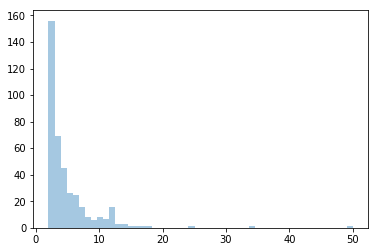

In [42]:
import matplotlib.pyplot as plt 
import seaborn as sns
all_counts = tri_sc+cbs_sc+mos_sc+sup_sc
# check frequency of stacked sites and maximum number of stacked sites
all_counts = [i for i in all_counts if i>1]
sns.distplot(all_counts,kde=False)

In [11]:
# put a site name on each site and add Full Address to TRI sites 
for myvar in mydict:
    print(myvar)
    varlen = len(mydict[myvar]['features'])
    print(varlen)
    for i in range(varlen):
        mydict[myvar]['features'][i]['properties']['SITE_NAME'] = myvar
        if myvar=='TRI':
           mydict[myvar]['features'][i]['properties']['Full Address'] = mydict[myvar]['features'][i]['properties']['STREET_ADDRESS']

TRI
632
CBS
86
MOSF
36
SUPERFUND2
45


In [14]:
# merge and save 
merged = tri
merged['features'] = merged['features']+cbs['features']+mos['features']+sup['features']
len(merged['features'])

# now write a geojson
output_filename = 'Data\\bulkstorage_converted.json'
with open(output_filename, 'w') as output_file:
    json.dump(merged, output_file, indent=2) 
print('saved as "'+ output_filename + '" !')

saved as "Data\bulkstorage_converted.json" !
